In [18]:
import torch
import glob
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import numpy as np
import kbrgan.plot as plot

Setting this and that

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
tensor_type = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
torch.set_default_tensor_type(tensor_type)

In [3]:
device_load_options = {} if use_cuda else {'map_location': lambda storage, loc: storage} 

In [4]:
n_sample = 16

In [5]:
latent_dim = 256
f_noise = lambda n: torch.randn(n, latent_dim).float()
Z0 = f_noise(n_sample)

Load model

In [6]:
class VAE(nn.Module):
    def __init__(self, nc, ngf, ndf, latent_variable_size):
        super(VAE, self).__init__()

        self.nc = nc
        self.ngf = ngf
        self.ndf = ndf
        self.latent_variable_size = latent_variable_size

        # encoder
        self.e1 = nn.Conv2d(nc, ndf, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(ndf)

        self.e2 = nn.Conv2d(ndf, ndf*2, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(ndf*2)

        self.e3 = nn.Conv2d(ndf*2, ndf*4, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(ndf*4)

        self.e4 = nn.Conv2d(ndf*4, ndf*8, 4, 2, 1)
        self.bn4 = nn.BatchNorm2d(ndf*8)

        self.e5 = nn.Conv2d(ndf*8, ndf*8, 4, 2, 1)
        self.bn5 = nn.BatchNorm2d(ndf*8)

        self.fc1 = nn.Linear(ndf*8*4*4, latent_variable_size)
        self.fc2 = nn.Linear(ndf*8*4*4, latent_variable_size)

        # decoder
        self.d1 = nn.Linear(latent_variable_size, ngf*8*2*4*4)

        self.up1 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd1 = nn.ReplicationPad2d(1)
        self.d2 = nn.Conv2d(ngf*8*2, ngf*8, 3, 1)
        self.bn6 = nn.BatchNorm2d(ngf*8, 1.e-3)

        self.up2 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd2 = nn.ReplicationPad2d(1)
        self.d3 = nn.Conv2d(ngf*8, ngf*4, 3, 1)
        self.bn7 = nn.BatchNorm2d(ngf*4, 1.e-3)

        self.up3 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd3 = nn.ReplicationPad2d(1)
        self.d4 = nn.Conv2d(ngf*4, ngf*2, 3, 1)
        self.bn8 = nn.BatchNorm2d(ngf*2, 1.e-3)

        self.up4 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd4 = nn.ReplicationPad2d(1)
        self.d5 = nn.Conv2d(ngf*2, ngf, 3, 1)
        self.bn9 = nn.BatchNorm2d(ngf, 1.e-3)

        self.up5 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd5 = nn.ReplicationPad2d(1)
        self.d6 = nn.Conv2d(ngf, nc, 3, 1)

        self.leakyrelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.leakyrelu(self.bn1(self.e1(x)))
        h2 = self.leakyrelu(self.bn2(self.e2(h1)))
        h3 = self.leakyrelu(self.bn3(self.e3(h2)))
        h4 = self.leakyrelu(self.bn4(self.e4(h3)))
        h5 = self.leakyrelu(self.bn5(self.e5(h4)))
        h5 = h5.view(-1, self.ndf*8*4*4)

        return self.fc1(h5), self.fc2(h5)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if args.cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h1 = self.relu(self.d1(z))
        h1 = h1.view(-1, self.ngf*8*2, 4, 4)
        h2 = self.leakyrelu(self.bn6(self.d2(self.pd1(self.up1(h1)))))
        h3 = self.leakyrelu(self.bn7(self.d3(self.pd2(self.up2(h2)))))
        h4 = self.leakyrelu(self.bn8(self.d4(self.pd3(self.up3(h3)))))
        h5 = self.leakyrelu(self.bn9(self.d5(self.pd4(self.up4(h4)))))

        return self.sigmoid(self.d6(self.pd5(self.up5(h5))))

    def get_latent_var(self, x):
        mu, logvar = self.encode(x.view(-1, self.nc, self.ndf, self.ngf))
        z = self.reparametrize(mu, logvar)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.nc, self.ndf, self.ngf))
        z = self.reparametrize(mu, logvar)
        res = self.decode(z)
        return res, mu, logvar
    
    def forward_mixture(self, x, output_size=1):
        mu, logvar = self.encode(x.view(-1, self.nc, self.ndf, self.ngf))
        z = self.reparametrize(mu, logvar)
        res = self.decode(z)
        return res, mu, logvar 

In [7]:
model = VAE(nc=3, ngf=128, ndf=128, latent_variable_size=500)

model.cuda()

model_path = '/notebooks/psangkloy3/condgan_share/prob_models/celeba_vae/cpu_Epoch_28_Train_loss_25425.9503_Test_loss_25172.4120.pth'

model.load_state_dict(torch.load(model_path))

images = glob.glob('../../condgan_share/celebahq_imgs/*')

totensor = transforms.ToTensor()
data = []
for img in images:
    image = Image.open(img)
    data.append(np.array(image.resize((128,128))))
data = [totensor(i) for i in data]
data = torch.stack(data, dim=0)

class Args():
    def __init__(self):
        self.cuda = True
args = Args()



In [49]:
model.eval()
#test_loss = 0
#for batch_idx in test_loader:
#data = load_batch(batch_idx, False)
x = Variable(data, volatile=True)
#if args.cuda:
x = x.cuda()
recon_batch, mu, logvar = model(x)

#x = data
output_size=2
gmm = torch.randint(high=x.shape[0]-1,size=(1,output_size)).cuda()

output_shape = (output_size,500)
res_mu = Variable(torch.Tensor(output_size,500)).cuda()
res_logvar = Variable(torch.Tensor(output_size,500)).cuda()
for i, g in enumerate(gmm[0]):
    res_mu[i] = mu[g]
    res_logvar[i] = logvar[g]

    

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """


In [50]:
z = model.reparametrize(res_mu, res_logvar)

recon = model.decode(z)

In [52]:
z.shape

torch.Size([2, 500])

tensor([ 5.6462e-01,  6.6851e-01,  5.4623e-01,  3.6843e-01,  8.9366e-01,
        -7.4860e-01, -8.4037e-02,  1.0439e+00,  1.6389e-01, -1.4908e+00,
         1.7388e-01, -6.9613e-01, -4.6709e-01,  9.3713e-01,  1.0016e+00,
         1.8005e-01, -1.0164e+00,  5.9100e-01,  8.0800e-01, -5.8117e-01,
        -4.3751e-01, -1.9940e+00,  1.9606e-02,  6.8590e-01, -7.7850e-02,
         1.8295e-01,  6.9068e-01, -4.9532e-01, -5.1096e-01, -5.9488e-01,
         7.2019e-01, -1.4151e-01, -3.5717e-01,  8.3082e-01, -1.0723e+00,
         3.1597e-01,  5.2766e-02, -1.4007e+00,  3.1873e-03,  8.8258e-02,
        -4.3954e-01, -1.3895e-01, -1.3602e+00,  1.2022e+00, -6.3537e-01,
         8.0027e-01,  7.2855e-02, -7.6280e-01, -3.7067e-01, -1.9582e-01,
         5.3116e-01, -6.6915e-01, -1.6298e-01, -7.7878e-01, -5.7634e-01,
         1.0586e+00,  7.1977e-01, -6.0939e-01,  4.1766e-01, -1.4835e-01,
         8.4511e-01,  2.9110e-01, -1.3479e+00,  4.1834e-01,  2.7501e-01,
         8.8494e-02,  4.6551e-01, -3.3255e-01, -3.4

In [64]:
def linear_interpolation(z1, z2, n):
    a = torch.linspace(0, 1, n)
    a = a.unsqueeze(0)
    A = torch.stack([a, 1-a])
    Z = torch.cat((z1, z2))
    torch.matmul()

In [61]:
z = model.reparametrize(res_mu, res_logvar)

new_z = (z[0]+z[1])/2.0

recon = model.decode(new_z)

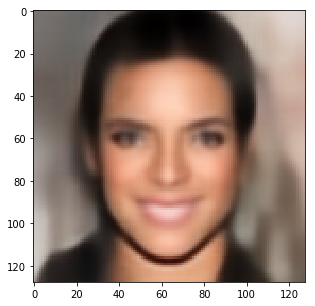

In [62]:
plot.show_torch_imgs(recon.data, nrow=5, normalize=True)

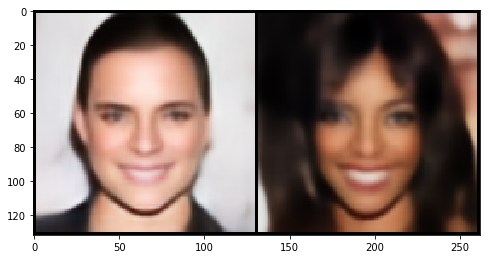

In [51]:
plot.show_torch_imgs(recon.data, nrow=5, normalize=True)

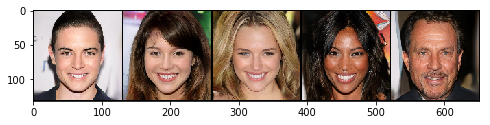

In [63]:
plot.show_torch_imgs(x.data, nrow=5, normalize=True)

In [108]:
torch.normal(mu[g], logvar[g]).shape

torch.Size([30, 500])

In [105]:
torch.Tensor(2)

tensor([2.8026e-45, 0.0000e+00])

In [8]:
model = VAE(nc=3, ngf=128, ndf=128, latent_variable_size=500)

model.cuda()

VAE(
  (e1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e5): Conv2d(1024, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=16384, out_features=500, bias=True)
  (fc2): Linear(in_features=16384, out_features=500, bias=True)
  (d1): Linear(in_features=500, ou

In [10]:
model_path = '/notebooks/psangkloy3/condgan_share/prob_models/celeba_vae/cpu_Epoch_28_Train_loss_25425.9503_Test_loss_25172.4120.pth'

model.load_state_dict(torch.load(model_path))

In [11]:
import kbrgan.plot as plot

In [12]:
images = glob.glob('../../condgan_share/celebahq_imgs/*')

In [13]:
totensor = transforms.ToTensor()
data = []
for img in images:
    image = Image.open(img)
    data.append(np.array(image.resize((128,128))))
data = [totensor(i) for i in data]
data = torch.stack(data, dim=0)

In [14]:
class Args():
    def __init__(self):
        self.cuda = True
args = Args()

In [60]:
model.eval()
#test_loss = 0
#for batch_idx in test_loader:
#data = load_batch(batch_idx, False)
data = Variable(data, volatile=True)
#if args.cuda:
data = data.cuda()
recon_batch, mu, logvar = model(data)
#test_loss += loss_function(recon_batch, data, mu, logvar).data[0]

#torchvision.utils.save_image(data.data, '../imgs/Epoch_{}_data.jpg'.format(epoch), nrow=8, padding=2)
#torchvision.utils.save_image(recon_batch.data, '../imgs/Epoch_{}_recon.jpg'.format(epoch), nrow=8, padding=2)

#test_loss /= (len(test_loader)*128)
#print('====> Test set loss: {:.4f}'.format(test_loss))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """


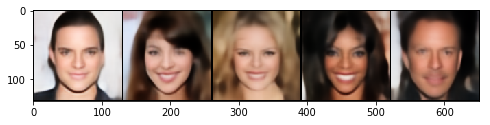

In [61]:
plot.show_torch_imgs(recon_batch.data, nrow=5, normalize=True)

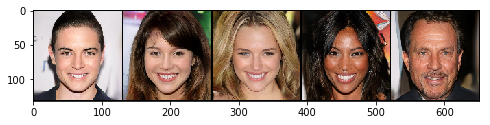

In [49]:
plot.show_torch_imgs(data, nrow=5, normalize=True)

In [37]:
torchvision.utils.save_image(recon.data, 'rand_faces.jpg', nrow=num, padding=2)